In [1]:
import copy
import numpy as np
import pandas as pd
import lightgbm as lgb
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from epigraphhub.data.get_data import get_cluster_data
from epigraphhub.analysis.clustering import compute_clusters
from epigraphhub.data.preprocessing import build_lagged_features

In [2]:
clusters = compute_clusters(
    "switzerland",
    "cases",
    ["datum", '"geoRegion"', "entries"],
    t=0.3,
    drop_georegions=["CH", "FL", "CHFL"],
)[1]

clusters

[array(['FR', 'GE', 'GR', 'JU', 'NE', 'TI', 'VD', 'VS'], dtype=object),
 array(['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'GL', 'LU', 'NW', 'OW', 'SG',
        'SH', 'SO', 'SZ', 'TG', 'UR', 'ZG', 'ZH'], dtype=object)]

In [3]:
df = get_cluster_data(
    ["cases", "hosp", "test"],
    ["FR", "GE", "GR", "JU", "NE", "TI", "VD", "VS"],
    vaccine=True,
    smooth=True,
)

df

,cases_TI,diff_cases_TI,diff_2_cases_TI,cases_FR,diff_cases_FR,diff_2_cases_FR,cases_NE,diff_cases_NE,diff_2_cases_NE,cases_GE,...,test_TI,diff_test_TI,diff_2_test_TI,test_NE,diff_test_NE,diff_2_test_NE,test_GE,diff_test_GE,diff_2_test_GE,vac_all
datum,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0.857143,0.000000,0.142857,0.285714,0.000000,0.285714,0.142857,0.142857,0.142857,1.428571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-02,1.428571,0.571429,0.714286,0.285714,0.000000,0.000000,0.142857,0.000000,0.142857,1.714286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-03,2.857143,1.428571,2.000000,0.714286,0.428571,0.428571,0.285714,0.142857,0.142857,1.714286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-04,3.857143,1.000000,2.428571,1.000000,0.285714,0.714286,1.285714,1.000000,1.142857,1.714286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-05,5.428571,1.571429,2.571429,1.142857,0.142857,0.428571,1.428571,0.142857,1.142857,1.857143,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-10,708.714286,-31.285714,-61.000000,1095.142857,-48.000000,-135.428571,599.857143,-33.857143,-92.285714,1067.000000,...,1978.571429,-46.428571,-104.000000,1382.571429,-147.285714,-257.428571,3541.000000,-167.142857,-416.428571,176.920000
2022-02-11,690.857143,-17.857143,-49.142857,1038.571429,-56.571429,-104.571429,566.857143,-33.000000,-66.857143,984.571429,...,1915.857143,-62.714286,-109.142857,1306.714286,-75.857143,-223.142857,3423.571429,-117.428571,-284.571429,177.045714
2022-02-12,681.714286,-9.142857,-27.000000,992.571429,-46.000000,-102.571429,548.142857,-18.714286,-51.714286,917.000000,...,1864.285714,-51.571429,-114.285714,1249.142857,-57.571429,-133.428571,3313.285714,-110.285714,-227.714286,177.164286


Testing some functions

In [4]:
from epigraphhub.models.sklearn_models import train_eval_mult_models

In [5]:
def lgbm_model(alpha=0.5, params=None, **kwargs):
    """
    Return an LGBM model
    :param kwargs:
    :return: LGBMRegressor model
    """
    if params is None:
        params = {
            "n_jobs": 8,
            "max_depth": 4,
            "max_bin": 63,
            "num_leaves": 255,
            #             'min_data_in_leaf': 1,
            "subsample": 0.9,
            "n_estimators": 200,
            "tree_learner": "feature",
            "learning_rate": 0.1,
            "colsample_bytree": 0.9,
            "boosting_type": "gbdt",
        }

    model = lgb.LGBMRegressor(objective="quantile", alpha=alpha, **params)

    return model

In [6]:
model = lgbm_model()

In [7]:
target_name = "hosp_GE"
maxlag = 21
ini_date = "2020-03-01"
data = df
split = 0.99999
horizon_forecast = 14

df_pred = train_eval_mult_models(
    model,
    target_name,
    df,
    split=0.75,
    horizon_forecast=14,
    maxlag=21,
)

In [9]:
df_pred

,target,date,predict,train_size
datum,,,,
2020-03-23,13.142857,2020-03-23,12.016283,521
2020-03-24,13.285714,2020-03-24,11.872317,521
2020-03-25,12.857143,2020-03-25,11.857389,521
2020-03-26,12.571429,2020-03-26,10.872328,521
2020-03-27,14.142857,2020-03-27,11.730346,521
...,...,...,...,...
2022-02-10,7.428571,2022-02-10,7.169495,521
2022-02-11,6.571429,2022-02-11,5.727198,521
2022-02-12,6.142857,2022-02-12,5.849633,521


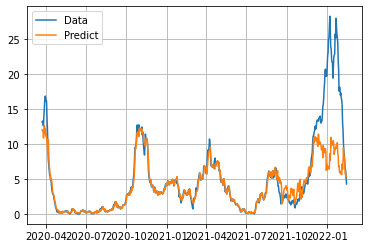

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df_pred.target, label="Data")

ax.plot(df_pred.predict, label="Predict")

ax.legend()

ax.grid()

plt.show()

In [8]:
X_train.shape

NameError: name 'X_train' is not defined

In [ ]:
X_test.shape